In [1]:
# CV Project 14 [Satya, Amal, Liyalisa, Shakti]

#Importing Libraries
import librosa
import pywt
import os
import matplotlib.pyplot as plt
import cv2
from sklearn.model_selection import train_test_split
from random import seed,random,randint,sample
from sklearn.decomposition import PCA
import tensorflow.keras as keras
from keras import backend as K
from keras.models import Model,load_model,Sequential
from keras.callbacks import ModelCheckpoint
from keras.layers import Input, Dense, Conv1D, GlobalMaxPool1D,Activation,MaxPool1D,Flatten,BatchNormalization
from keras.regularizers import l2
from keras.utils import to_categorical
from keras.optimizers import Adam
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.preprocessing import MinMaxScaler
from scipy.signal import hilbert, chirp
from sklearn.model_selection import StratifiedKFold
from tqdm import tqdm
import numpy as np
import glob as gb


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
DATASET_PATH = r"/content/drive/My Drive/KAUH"
train_data = []
train_label = []
train_sr = []
for i in os.listdir(DATASET_PATH):
    files = gb.glob(pathname = str(DATASET_PATH+'/'+i+"/*.wav"))
    print(f"Number of {i} sound files", len(files))
    sound_class = {'normal':0,'abnormal':1,}
    for j in files:
        #sample_rate, data = wav.read(j)
        data , sample_rate = librosa.load(j)
        #print(data)
        train_data.append(data)
        train_sr.append(sample_rate)
        train_label.append(sound_class[i])

Number of normal sound files 239
Number of abnormal sound files 226


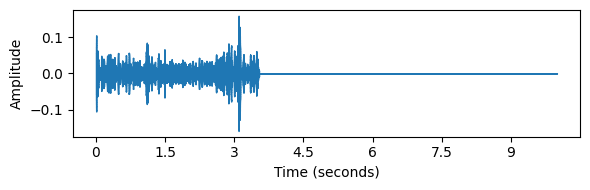

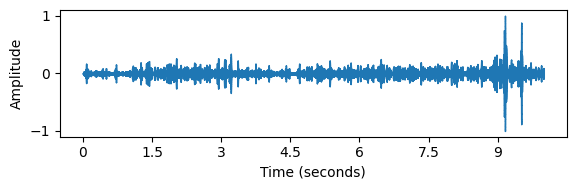

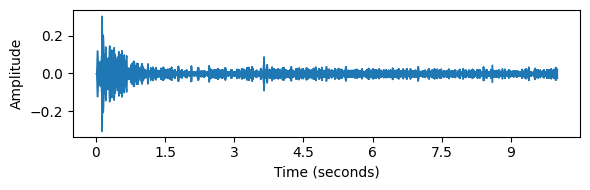

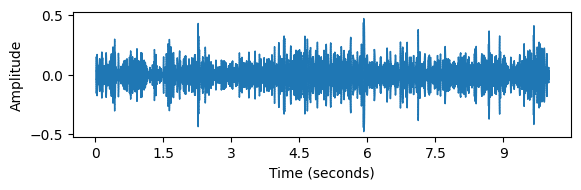

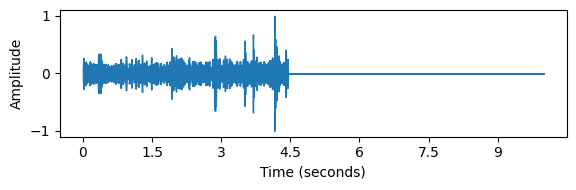

In [9]:
def plot_wave(data,sample_rate):
  plt.figure(figsize=(6, 2))
  librosa.display.waveshow(data, sr=sample_rate)
  plt.xlabel('Time (seconds)')
  plt.ylabel('Amplitude')
  plt.tight_layout()

for i in range(5):
  x = np.random.randint(len(train_data))
  plot_wave(train_data[x],train_sr[x])

In [10]:
train_cwt = []
for i in range(len(train_data)):
    new_sample_rate = 500
    #resampled_data = resample(data,int(len(data)*(new_sample_rate/sample_rate)))
    resampled_data = librosa.resample(train_data[i],orig_sr = train_sr[i], target_sr = new_sample_rate)
    coeff, freq = pywt.cwt(resampled_data, scales=np.arange(1,128), wavelet='morl')
    train_cwt.append(coeff)

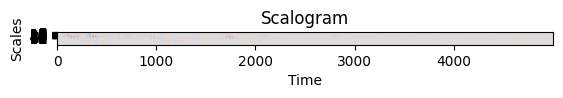

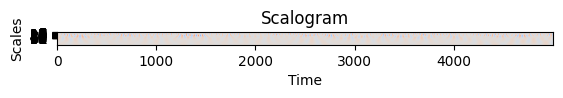

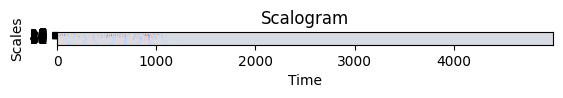

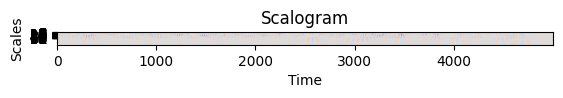

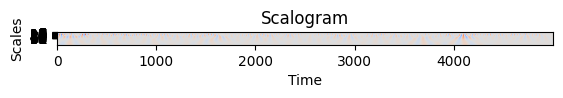

In [11]:
widths = np.arange(1, 64)
def plot1(wave_coeff):
  plt.imshow(wave_coeff, cmap='coolwarm')
  plt.xlabel("Time")
  plt.ylabel("Scales")
  plt.yticks(widths)
  plt.title("Scalogram")
  plt.show()

for i in range(5):
  x = np.random.randint(len(train_cwt))
  plot1(train_cwt[x])

In [12]:
train_cwt = np.array(train_cwt)
train_cwt.shape

(465, 127, 5000)

In [13]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( train_cwt, train_label, test_size=0.2, random_state=42)
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

In [14]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((372, 127, 5000), (93, 127, 5000), (372,), (93,))

In [15]:
from keras.utils import to_categorical
y_train = to_categorical(y_train, 2)
y_test = to_categorical(y_test, 2)

In [16]:
from keras.models import Sequential
from keras.layers import Flatten, Dense, Conv2D, MaxPooling2D

In [17]:
n , x, y = X_train.shape

In [18]:
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense

model = Sequential()
model.add(Conv1D(32, 3, activation='relu', input_shape=(x, y)))  # Note: No need to specify the input channels
model.add(MaxPooling1D(2))
model.add(Conv1D(128, 3, activation='relu'))
model.add(MaxPooling1D(2))
model.add(Conv1D(128, 3, activation='relu'))
model.add(MaxPooling1D(2))
model.add(Conv1D(128, 3, activation='relu'))
model.add(MaxPooling1D(2))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(2, activation='softmax'))  # Changed to softmax for binary classification
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 125, 32)           480032    
                                                                 
 max_pooling1d (MaxPooling1  (None, 62, 32)            0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 60, 128)           12416     
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 30, 128)           0         
 g1D)                                                            
                                                                 
 conv1d_2 (Conv1D)           (None, 28, 128)           49280     
                                                                 
 max_pooling1d_2 (MaxPoolin  (None, 14, 128)           0

In [19]:
test_accuracy = []
hist = []
loss = []
for i in range(2):
  print("Step",i+1)
  _hist = model.fit(X_train, y_train, batch_size=32, epochs=5, validation_data=(X_test, y_test))
  _loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
  test_accuracy.append(test_acc)
  loss.append(_loss)
  hist.append(_hist)

mean_acc = np.mean(np.array(test_accuracy))
print(f"the mean accuracy is {mean_acc}")


Step 1
Epoch 1/5
12/12 [==============================] - 7s 412ms/step - loss: 0.6797 - accuracy: 0.5511 - val_loss: 0.6230 - val_accuracy: 0.5806
Epoch 2/5
12/12 [==============================] - 5s 384ms/step - loss: 0.4386 - accuracy: 0.8387 - val_loss: 0.5121 - val_accuracy: 0.7957
Epoch 3/5
12/12 [==============================] - 6s 542ms/step - loss: 0.2807 - accuracy: 0.9113 - val_loss: 0.5090 - val_accuracy: 0.8065
Epoch 4/5
12/12 [==============================] - 6s 491ms/step - loss: 0.1671 - accuracy: 0.9570 - val_loss: 0.3930 - val_accuracy: 0.8280
Epoch 5/5
12/12 [==============================] - 6s 503ms/step - loss: 0.1102 - accuracy: 0.9785 - val_loss: 0.8272 - val_accuracy: 0.7849
Step 2
Epoch 1/5
12/12 [==============================] - 7s 606ms/step - loss: 0.1033 - accuracy: 0.9812 - val_loss: 0.7655 - val_accuracy: 0.8387
Epoch 2/5
12/12 [==============================] - 7s 562ms/step - loss: 0.2429 - accuracy: 0.9543 - val_loss: 0.3335 - val_accuracy: 0.8925

Step 1


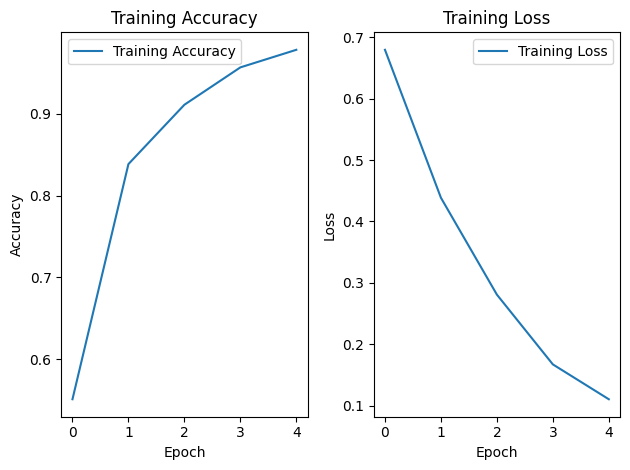

Step 2


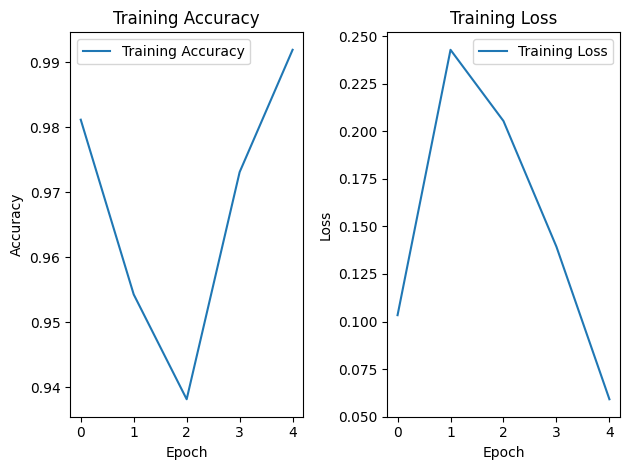

In [20]:
def plot_training(history):
    # Plot training accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.title('Training Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot training loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Plot training accuracy and loss for the above model
for i in range(len(hist)):
  print("Step",i+1)
  plot_training(hist[i])

3/3 [==============================] - 1s 125ms/step


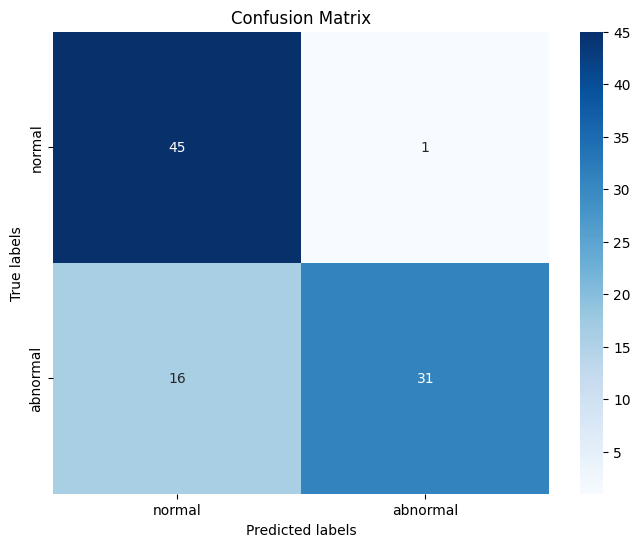

In [21]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Predictions on test data

y_pred_probabilities = model.predict(X_test)
y_pred = np.argmax(y_pred_probabilities, axis=1)
y_test1 = np.argmax(y_test, axis=1)
# Generate confusion matrix
conf_matrix = confusion_matrix(y_test1, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['normal','abnormal'], yticklabels=['normal','abnormal'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()


Class normal - Sensitivity: 0.98, Specificity: 0.66, Accuracy: 0.82, Precision: 0.74, Recall: 0.98, F1 Score: 0.84
Class abnormal - Sensitivity: 0.66, Specificity: 0.98, Accuracy: 0.82, Precision: 0.97, Recall: 0.66, F1 Score: 0.78

Average Sensitivity: 0.82
Average Specificity: 0.82
Average Accuracy: 0.82
Average Precision: 0.85
Average Recall: 0.82
Average F1 Score: 0.81


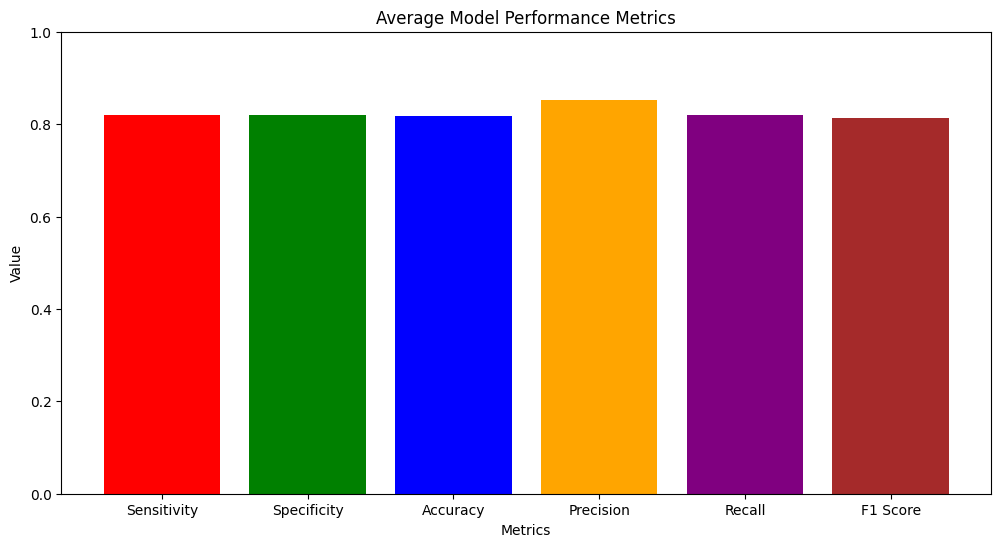

In [22]:
# Define the class names for the two-class problem
s_class = ['normal', 'abnormal']

# Initialize lists to store metrics for each class
sensitivity_list = []
specificity_list = []
accuracy_list = []
precision_list = []
recall_list = []
f1_list = []

# Calculate metrics for each class
for i in range(2):  # Loop over the two classes
    TP = conf_matrix[i, i]  # True Positive
    FN = sum(conf_matrix[i, :]) - TP  # False Negative
    FP = sum(conf_matrix[:, i]) - TP  # False Positive
    TN = sum(conf_matrix.flatten()) - (TP + FP + FN)  # True Negative

    sensitivity = TP / (TP + FN) if (TP + FN) != 0 else 0
    specificity = TN / (TN + FP) if (TN + FP) != 0 else 0
    accuracy = (TP + TN) / sum(conf_matrix.flatten()) if sum(conf_matrix.flatten()) != 0 else 0
    precision = TP / (TP + FP) if (TP + FP) != 0 else 0
    recall = TP / (TP + FN) if (TP + FN) != 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0

    sensitivity_list.append(sensitivity)
    specificity_list.append(specificity)
    accuracy_list.append(accuracy)
    precision_list.append(precision)
    recall_list.append(recall)
    f1_list.append(f1)

    print(f"Class {s_class[i]} - Sensitivity: {sensitivity:.2f}, Specificity: {specificity:.2f}, Accuracy: {accuracy:.2f}, Precision: {precision:.2f}, Recall: {recall:.2f}, F1 Score: {f1:.2f}")

# Calculate average metrics across classes
avg_sensitivity = sum(sensitivity_list) / len(sensitivity_list)
avg_specificity = sum(specificity_list) / len(specificity_list)
avg_accuracy = sum(accuracy_list) / len(accuracy_list)
avg_precision = sum(precision_list) / len(precision_list)
avg_recall = sum(recall_list) / len(recall_list)
avg_f1 = sum(f1_list) / len(f1_list)

print(f"\nAverage Sensitivity: {avg_sensitivity:.2f}")
print(f"Average Specificity: {avg_specificity:.2f}")
print(f"Average Accuracy: {avg_accuracy:.2f}")
print(f"Average Precision: {avg_precision:.2f}")
print(f"Average Recall: {avg_recall:.2f}")
print(f"Average F1 Score: {avg_f1:.2f}")

# Plot the average metrics
metrics = ['Sensitivity', 'Specificity', 'Accuracy', 'Precision', 'Recall', 'F1 Score']
values = [avg_sensitivity, avg_specificity, avg_accuracy, avg_precision, avg_recall, avg_f1]

plt.figure(figsize=(12, 6))
plt.bar(metrics, values, color=['red', 'green', 'blue', 'orange', 'purple', 'brown'])
plt.title('Average Model Performance Metrics')
plt.xlabel('Metrics')
plt.ylabel('Value')
plt.ylim(0, 1)
plt.show()
